In [2]:
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import arviz as az
import pymc3 as pm

In [19]:
# load data
with open('../data/shuangseqiu.pkl', 'rb') as f:
    data = pkl.load(f)
    
    
df = pd.DataFrame(data)[['date', 'red_balls', 'blue_ball']]
for i in range(6):
    df[f'red_ball_{i+1}'] = df['red_balls'].apply(lambda x: x[i])

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date', ascending=True).reset_index(drop=True)
df.tail()

,date,red_balls,blue_ball,red_ball_1,red_ball_2,red_ball_3,red_ball_4,red_ball_5,red_ball_6
2769,2021-11-04,"[19, 20, 23, 27, 28, 31]",1,19,20,23,27,28,31
2770,2021-11-07,"[7, 15, 16, 20, 27, 29]",7,7,15,16,20,27,29
2771,2021-11-09,"[5, 17, 20, 21, 23, 33]",4,5,17,20,21,23,33
2772,2021-11-11,"[4, 15, 21, 27, 28, 29]",10,4,15,21,27,28,29
2773,2021-11-14,"[8, 9, 15, 24, 26, 30]",6,8,9,15,24,26,30


In [27]:
def as_binary_repr(x, total):
    out = np.zeros(total, dtype=int)
    index = np.asarray(x) - 1
    out[index] = 1
    return out

df['red_ball_binary'] = df['red_balls'].apply(lambda x: as_binary_repr(x, 33))
df['blue_ball_binary'] = df['blue_ball'].apply(lambda x: as_binary_repr(x, 16))
df.head()

,date,red_balls,blue_ball,red_ball_1,red_ball_2,red_ball_3,red_ball_4,red_ball_5,red_ball_6,red_ball_binary,blue_ball_binary
0,2003-02-23,"[10, 11, 12, 13, 26, 28]",11,10,11,12,13,26,28,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
1,2003-02-27,"[4, 9, 19, 20, 21, 26]",12,4,9,19,20,21,26,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
2,2003-03-02,"[1, 7, 10, 23, 28, 32]",16,1,7,10,23,28,32,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,2003-03-06,"[4, 6, 7, 10, 13, 25]",3,4,6,7,10,13,25,"[0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,2003-03-09,"[4, 6, 15, 17, 30, 31]",16,4,6,15,17,30,31,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"


In [54]:
observed_red = np.vstack(df['red_ball_binary'].head(5).values)
observed_blue = np.vstack(df['blue_ball_binary'].head(5).values)

# Approach 1
红球范围1-33，蓝球范围1-16。将红球和篮球分别用[Dirichilet](https://docs.pymc.io/en/v3/api/distributions/multivariate.html#pymc3.distributions.multivariate.Dirichlet)分布表示

In [62]:
def _uniform_init(n):
    return np.ones(n) / n

with pm.Model():
    red_prob = pm.Dirichlet(name='red_prob', a=[0.5] * 33)
    blue_prob = pm.Dirichlet(name='blue_prob', a=[0.5] * 16)
#     red_prob = pm.Normal(name='red_prob', mu=0.5, sigma=0.1, shape=33)
#     blue_prob = pm.Normal(name='blue_prob', mu=0.5, sigma=0.1, shape=16)
    
    red = pm.DirichletMultinomial('red_ball', n=6, a=red_prob, shape=33, observed=observed_red)
    blue = pm.DirichletMultinomial('blue_ball', n=1, a=blue_prob, shape=16, observed=observed_blue)
    idata = pm.sample(2000, tune=1500, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_prob, red_prob]


Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 44 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [64]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<AxesSubplot:title={'center':'red_prob'}>,
        <AxesSubplot:title={'center':'red_prob'}>],
       [<AxesSubplot:title={'center':'blue_prob'}>,
        <AxesSubplot:title={'center':'blue_prob'}>]], dtype=object)

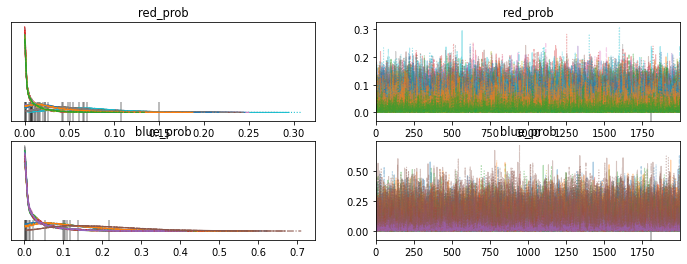

In [65]:
az.plot_trace(idata)

In [68]:
df_post_summary = az.summary(idata)
df_post_summary.head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
red_prob[0],0.032,0.026,0.000,0.079,0.000,0.0,4848.0,2939.0,1.0
red_prob[1],0.011,0.014,0.000,0.037,0.000,0.0,3191.0,1967.0,1.0
red_prob[2],0.011,0.016,0.000,0.038,0.000,0.0,3502.0,1836.0,1.0
red_prob[3],0.075,0.039,0.012,0.148,0.001,0.0,4971.0,3560.0,1.0
red_prob[4],0.011,0.015,0.000,0.038,0.000,0.0,3448.0,2591.0,1.0


<AxesSubplot:>

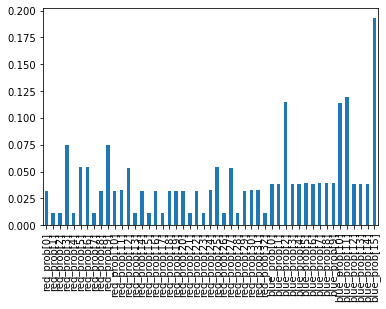

In [72]:
df_post_summary['mean'].plot(kind='bar')

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

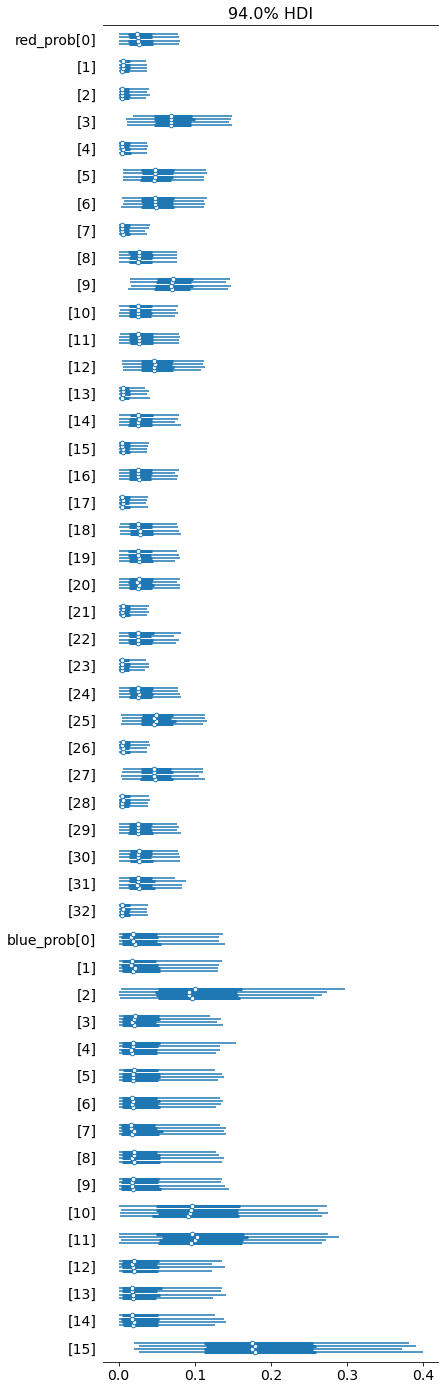

In [74]:
az.plot_forest(idata, r_hat=False)